# Seminar 3: Computing the Transfer Function and Simulating the Room Effect

## Acoustic Engineering 2024-2025

Genís Plaja - genis.plaja@upf.edu, Adriana Modrego - adriana.modrego@upf.edu, Zat Pros - zat.pros01@estudiant.upf.edu, Office 55.312
__<p>28<sup>th</sup> OCTOBER 2024<p>__

## Instructions for submission

Like in the previous seminar session, you will have to submit this *jupyter notebook* with all the answers.

__Considerations__:
* Comment the code when needed.
* **ALL RESPONSES MUST BE JUSTIFIED.** There is no need to submit a *report* but you need to explain your
* **PLEASE DO NOT SEND YOUR GENERATED AUDIOS BUT DO SEND THE EXTERNAL AUDIO FILES YOU USE TO COMPLETE YOUR LAB. OTHERWISE I WON'T BE ABLE TO EXECUTE IT.**
* You can upload files to Collab!




In [540]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy
from scipy.io.wavfile import read
from scipy.io.wavfile import write
from scipy.fft import fft
from scipy import signal as signal

import soundfile as sf

In [541]:
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate


## Exercise 1: Transfer Function Analysis

In this exercise, we focus on computing the transfer function (TF) between a dry sound (synthesized in the previous lab) `x(t)` and a wet sound (original) `y(t)`. The goal is to analyze how the synthesized version differs from the original by applying the Fourier Transform to both signals. By calculating the ratio of the wet sound's Fourier Transform to the dry sound's Fourier Transform, we obtain the transfer function, which gives insight into how the system modified the sound during synthesis. To fully understand this process, students are expected to research transfer functions, study their role in signal processing, and explore how they reveal system characteristics. Key formulas, such as:
$$H(f) = \frac{Y(f)}{X(f)}$$


In [542]:
def singen(A, duration, f, phi, step):
  t = np.arange(0, duration, step)
  x = A * np.sin(2 * np.pi * f * t + phi)
  return x

def synth(f0, dur, fs):
  n = 10
  A = [1220,284, 230, 50, 28, 12, 9, 8, 14, 1.5]
  result = 0
  for i in range(1,n+1):
    result += singen(A[i-1], dur, f0*i, 0, 1/fs)
  return result

def FFTvisualize(xx, Nfft, fs):
    # Codi aquí. Podeu afegir més paràmetres d'entrada si us calen.
    zz = np.abs(np.fft.fft(xx, n=Nfft))
    xf = np.arange(0, fs, fs/float(Nfft))

    plt.figure(figsize=(15,5))
    plt.plot(xf[:int(Nfft/2)], zz[:int(Nfft/2)])
    plt.xlim(0,6000)
    plt.grid()
    plt.title('Saxophone Soprano Note D5')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Energy')





/var/folders/k3/348v33yx5lqd30gcv72z1ty80000gn/T/ipykernel_45447/2892807941.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, x = read(file)


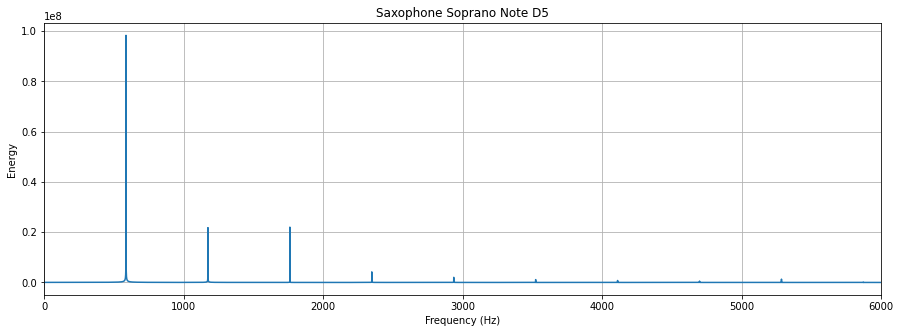

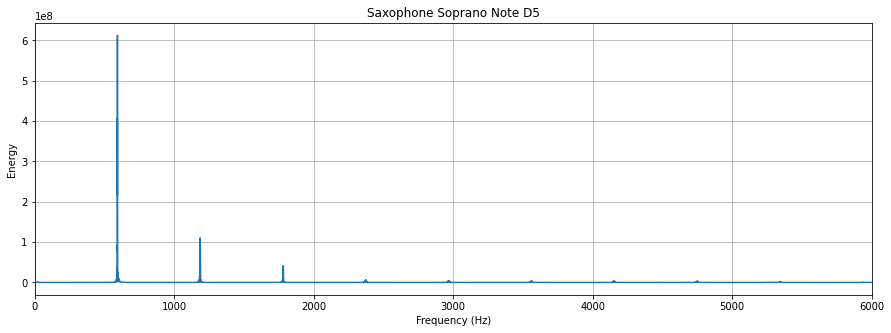

In [543]:
y, fs = read_sound('../AE_S3/359681__mtg__sax-soprano-d5.wav')

f0 = 587.33
x = synth(f0, 4, fs)


FFTvisualize(x, len(x), fs)
ipd.display(ipd.Audio(data=x, rate=fs))

FFTvisualize(y, len(y), fs)
ipd.display(ipd.Audio(data=y, rate=fs))


<div class="alert alert-block alert-success">

__a) Research the concept of transfer functions and their significance in sound analysis. In your response, explain what transfer functions represent, how they can be analyzed, and what insights they provide about a system's behavior. Consider aspects such as amplitude and phase modifications, resonance, and potential applications in sound engineering. Reflect on how understanding transfer functions can improve sound quality and system design.__

</div>


<div class="alert alert-block alert-success">

__b) Time to get your hands dirty! Let’s compute the Fourier Transforms for both the dry sound (the original) and the wet sound (the synthesized version) using the `fft` function from `numpy`. Make sure to store the Fourier Transform of the dry sound in the variable `X_f` and the wet sound in `Y_f`.__ 

</div>



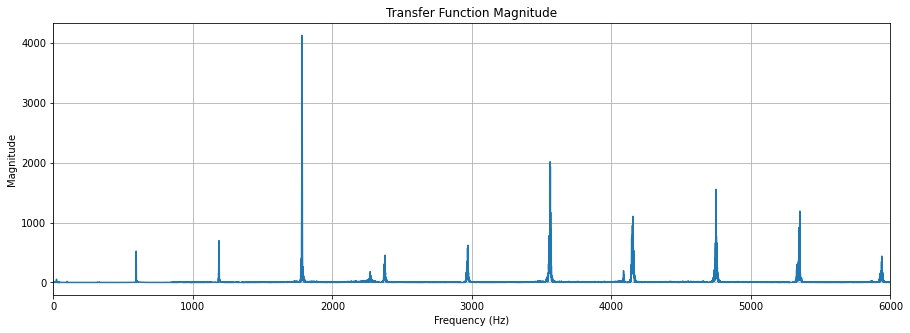

In [544]:
X_f = np.fft.fft(x)  # Compute FFT
X_f_magnitude = np.abs(X_f)  # Magnitude of FFT


Y_f = np.fft.fft(y)  # Compute FFT
Y_f_magnitude = np.abs(Y_f)  # Magnitude of FFT

H_f = Y_f / X_f  # Transfer function
H_f_magnitude = np.abs(H_f)  # Magnitude of transfer function

# Print the transfer function magnitude
frequencies = np.fft.fftfreq(len(X_f), d=1/fs)  # Frequency bins
plt.figure(figsize=(15, 5))
plt.plot(frequencies[:len(frequencies)//2], H_f_magnitude[:len(H_f_magnitude)//2])
plt.grid()
plt.title('Transfer Function Magnitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 6000)
plt.show()


<div class="alert alert-block alert-success">

__c) Perform the calculation of the transfer function by dividing the Fourier Transform of the wet sound (`Y_f`) by the Fourier Transform of the dry sound (`X_f`). Store the result in the variable `H_f`, and print the resulting transfer function to analyze the results.__

</div>


<div class="alert alert-block alert-success">

__d) Now it's time to dive deep into the analysis of your resulting transfer function `H_f`. What do you observe about its amplitude and phase characteristics? Are there any notable peaks or dips in the spectrum? How do these features correlate with the dry and wet sounds? Discuss what these observations reveal about the system's effects on the sound. Specifically, consider the following questions: What frequencies are most affected? Are there any signs of resonance or distortion? How might these characteristics influence sound quality and reproduction? Be detailed in your observations and explanations!__ 

</div>


## Exercise 2: Impulse Response as a Filter

In this exercise, we will take the transfer function derived from Exercise 1 and convert it into an impulse response. 

$$h(t) = \mathcal{F}^{-1}\{H(f)\}$$

This impulse response will act as a filter that we will apply to the dry sound through convolution, which can be expressed mathematically as:

$$y(t) = h(t)*x(t)$$

Our goal is to modify the synthesized sound so that it closely resembles the original sound, allowing us to analyze the filtering effects of the system. You will compute the impulse response, apply the filter, and then discuss your observations regarding the results

<div class="alert alert-block alert-success">

__a) Compute the impulse response `h(t)` using the inverse Fourier Transform of the transfer function `H(f)`. Store the impulse response in a variable and visualize it to see how the system modifies the sound over time.__

</div>

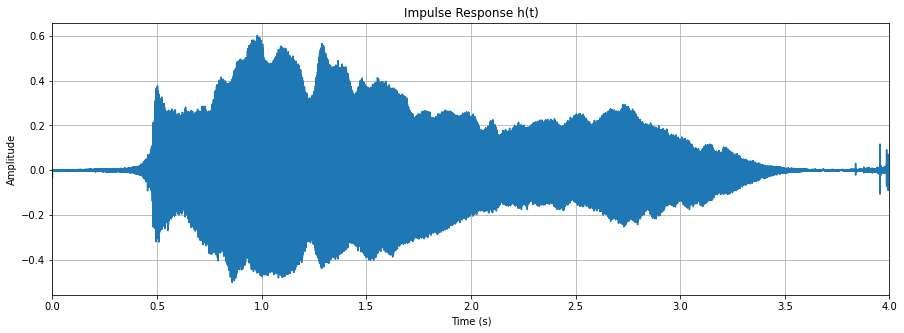

In [545]:
# Compute the transfer function
H_f = Y_f / X_f # Transfer function, ensure shapes match

# Compute the impulse response h(t) using the inverse Fourier Transform
h_t = np.fft.ifft(H_f)  # Inverse FFT to obtain impulse response
h_t_real = np.real(h_t)  # Take the real part if necessary

# Time vector for impulse response
t = np.arange(len(h_t_real)) / fs  # Time vector

# Visualize the impulse response
plt.figure(figsize=(15, 5))
plt.plot(t, h_t_real)
plt.title('Impulse Response h(t)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 4)  # Limit x-axis to a specific range for better visibility
plt.show()

# Save the impulse response to a WAV file if needed
write('impulse_response.wav', fs, np.int16(h_t_real / np.max(np.abs(h_t_real)) * 32767))
ipd.display(ipd.Audio(data=np.int16(h_t_real / np.max(np.abs(h_t_real)) * 32767), rate=fs))


<div class="alert alert-block alert-success">

__b) Comment on the resulting impulse response. What characteristics do you observe? Discuss any notable features, such as peaks or decay behavior, and how they might affect the sound when applied as a filter.__

</div>

<div class="alert alert-block alert-success">

__c) Apply the computed impulse response `h(t)` as a filter to the dry sound `x(t)` using convolution. Store the filtered output in a variable and visualize the resulting sound to compare it with the wet sound.__

</div>

Length of dry signal (x): 192000
Length of impulse response (h): 192000
Length of filtered output (full convolution): 383999


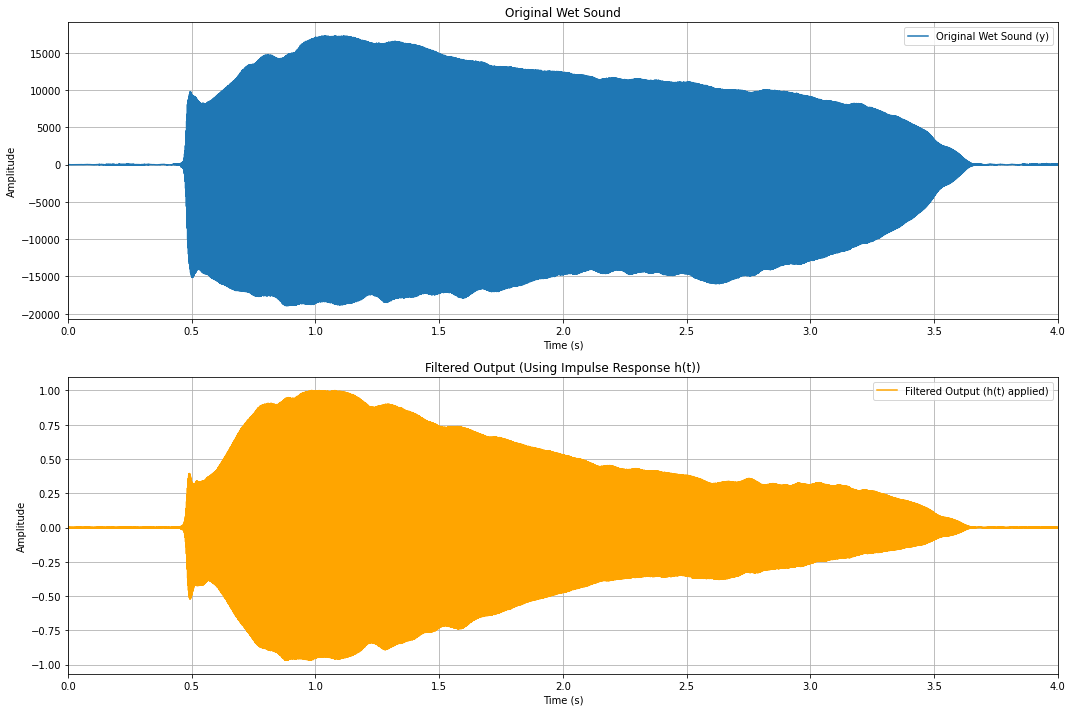

In [546]:
# Apply the computed impulse response as a filter to the dry sound x(t) using convolution
filtered_output_full = np.convolve(x, h_t_real, mode='full')  # Use 'full' to capture the entire response

# Print the lengths to verify
print(f"Length of dry signal (x): {len(x)}")
print(f"Length of impulse response (h): {len(h_t_real)}")
print(f"Length of filtered output (full convolution): {len(filtered_output_full)}")

# Normalize the filtered output to prevent clipping
if np.max(np.abs(filtered_output_full)) != 0:  # Avoid division by zero
    filtered_output = filtered_output_full / np.max(np.abs(filtered_output_full))  # Normalize

# Use only the first len(x) samples if necessary
filtered_output = filtered_output[:len(x)]  # Keep the same length as the original signal

# Visualize the filtered output and the wet sound for comparison
plt.figure(figsize=(15, 10))

# Plot  wet sound
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(y)) / fs, y, label='Original Wet Sound (y)')
plt.title('Original Wet Sound')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 4)  # Limit x-axis for better visibility
plt.legend()

# Plot filtered output
plt.subplot(2, 1, 2)
plt.plot(np.arange(len(filtered_output)) / fs, filtered_output, label='Filtered Output (h(t) applied)', color='orange')
plt.title('Filtered Output (Using Impulse Response h(t))')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 4)  # Limit x-axis for better visibility
plt.legend()

plt.tight_layout()
plt.show()

# Save the filtered output to a WAV file if needed
ipd.display(ipd.Audio(data=np.int16(y / np.max(np.abs(y)) * 32767), rate=fs))
ipd.display(ipd.Audio(data=np.int16(filtered_output / np.max(np.abs(filtered_output)) * 32767), rate=fs))



<div class="alert alert-block alert-success">

__d) Comment on the result of the filtered sound. How closely does it resemble the wet sound? Discuss any differences or similarities you observe and what they might indicate about the filtering process.__

</div>

<div class="alert alert-block alert-success">

__e) Generate and compare the spectra of the filtered sound and the wet sound. Examine the similarities and differences in their frequency content, noting any shifts, attenuations, or amplifications in specific frequency bands.__

</div>

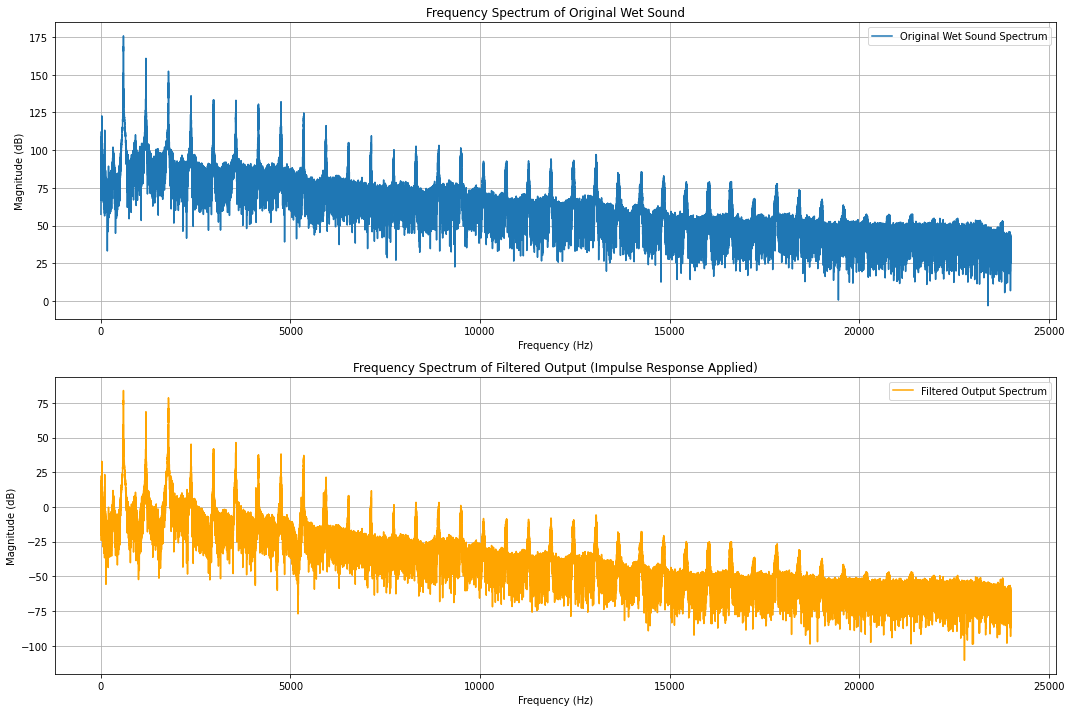

In [547]:
# Compute and visualize the frequency spectra of the wet and filtered sounds

# Perform Fourier Transform on wet sound
Y_wet = np.fft.fft(y)
freq_wet = np.fft.fftfreq(len(y), 1 / fs)

# Perform Fourier Transform on filtered output
Y_filtered = np.fft.fft(filtered_output)
freq_filtered = np.fft.fftfreq(len(filtered_output), 1 / fs)

# Plot the magnitude spectrum for both signals
plt.figure(figsize=(15, 10))

# Plot spectrum of the wet sound
plt.subplot(2, 1, 1)
plt.plot(freq_wet[:len(freq_wet)//2], 20 * np.log10(np.abs(Y_wet[:len(Y_wet)//2])), label='Original Wet Sound Spectrum')
plt.title('Frequency Spectrum of Original Wet Sound')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()

# Plot spectrum of the filtered output
plt.subplot(2, 1, 2)
plt.plot(freq_filtered[:len(freq_filtered)//2], 20 * np.log10(np.abs(Y_filtered[:len(Y_filtered)//2])), color='orange', label='Filtered Output Spectrum')
plt.title('Frequency Spectrum of Filtered Output (Impulse Response Applied)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


## Exercise 3: Room effect

In this side quest, you'll take your exploration of sound further by engaging in a practical recording exercise. Choose a sound and play it in a room. Using your mobile phone or another recording device, record the output of the sound in that environment. Once you have your recording, trim it so that its duration and content closely match the original sound. You will then upload this trimmed recording to your notebook.



<div class="alert alert-block alert-success">

__a) Record a sound and play it in a room. Use a mobile phone or another recording device to capture the output. Trim the recording so that its duration and content match the original sound, and upload the trimmed sound file to your notebook.__

</div>

/var/folders/k3/348v33yx5lqd30gcv72z1ty80000gn/T/ipykernel_45447/3934378946.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, x = read(file)


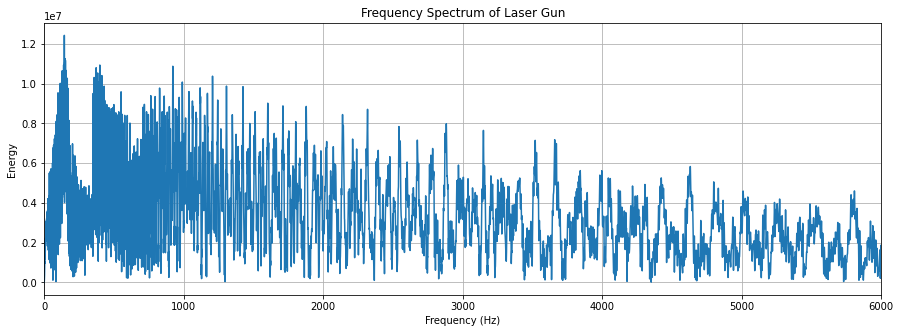

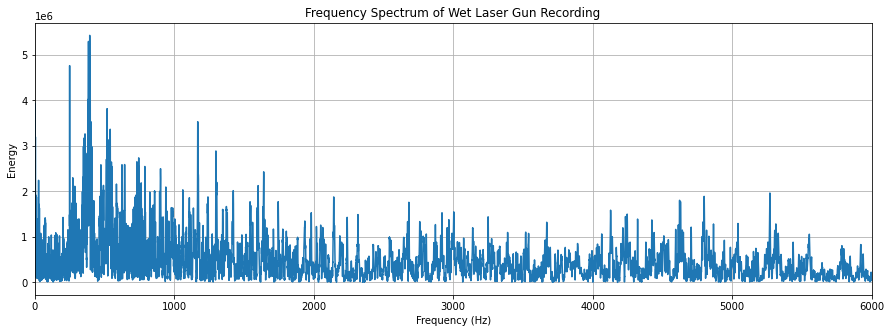

In [548]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  sound_array = sound_array.sum(axis=1) / 2
  return sound_array, sampling_rate

def FFTvisualize(xx, Nfft, fs, title="Frequency Spectrum"):
    """
    Visualizes the FFT of an audio signal.
    Args:
        xx (numpy.array): Audio signal array.
        Nfft (int): Number of points for the FFT.
        fs (int): Sampling rate of the audio signal.
        title (str): Title for the plot.
    """
    zz = np.abs(np.fft.fft(xx, n=Nfft))
    xf = np.linspace(0, fs, Nfft)

    plt.figure(figsize=(15, 5))
    plt.plot(xf[:Nfft // 2], zz[:Nfft // 2])
    plt.xlim(0, 6000)
    plt.grid()
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Energy')
    plt.show()



x, fs = read_sound('../AE_S3/LASER_GUN_ORIGINAL.wav')
y, fs = read_sound('../AE_S3/LASER_GUN_RECORDING.wav')


FFTvisualize(x, len(x), fs, "Frequency Spectrum of Laser Gun")
ipd.display(ipd.Audio(data=x, rate=fs))

FFTvisualize(y, len(y), fs, "Frequency Spectrum of Wet Laser Gun Recording")
ipd.display(ipd.Audio(data=y, rate=fs))

171929
171927


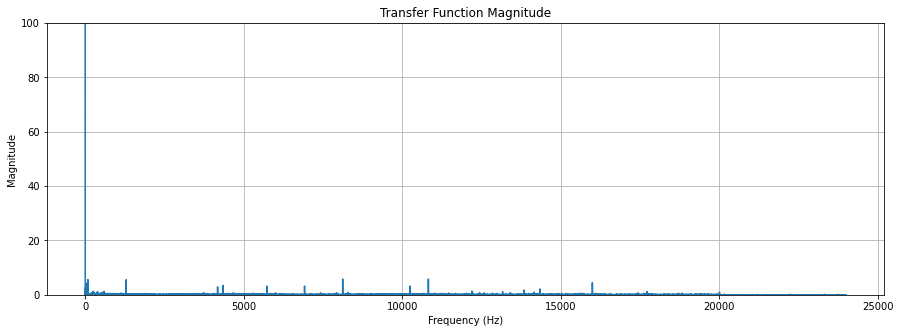

In [549]:
min_length = min(len(x), len(y))
print(len(x))
print(len(y))
x = x[:min_length]
y = y[:min_length]

X_f = np.fft.fft(x)  # Compute FFT
X_f_magnitude = np.abs(X_f)  # Magnitude of FFT

Y_f = np.fft.fft(y)  # Compute FFT
Y_f_magnitude = np.abs(Y_f)  # Magnitude of FFT

H_f = Y_f / X_f  # Transfer function

H_f_magnitude = np.abs(H_f)  # Magnitude of transfer function

# Print the transfer function magnitude
frequencies = np.fft.fftfreq(len(H_f), d=1/fs)  # Frequency bins
plt.figure(figsize=(15, 5))
plt.plot(frequencies[:len(frequencies)//2], H_f_magnitude[:len(H_f_magnitude)//2])
plt.grid()
plt.title('Transfer Function Magnitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0, 100)
plt.show()


<div class="alert alert-block alert-success">

__b) Perform the transfer function analysis on the recorded sound. Compute the impulse response and apply it to the dry sound (original sound) using convolution. Store the filtered output and visualize it.__

</div>

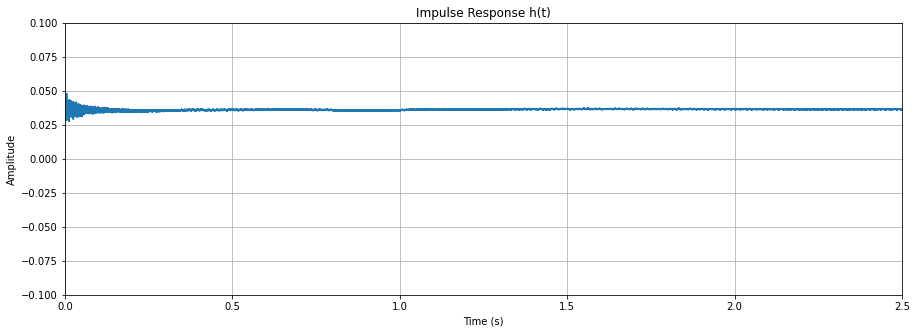

In [550]:
# Compute the impulse response h(t) using the inverse Fourier Transform
h_t = np.fft.ifft(H_f)  # Inverse FFT to obtain impulse response
h_t_real = np.real(h_t)  # Take the real part if necessary

# Time vector for impulse response
t = np.arange(len(h_t_real)) / fs  # Time vector

# Visualize the impulse response
plt.figure(figsize=(15, 5))
plt.plot(t, h_t_real)
plt.title('Impulse Response h(t)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.ylim(-0.1,0.1)
plt.xlim(0, 2.5)  # Limit x-axis to a specific range for better visibility
plt.show()

# Save the impulse response to a WAV file if needed
write('impulse_response.wav', fs, np.int16(h_t_real / np.max(np.abs(h_t_real)) * 32767))
ipd.display(ipd.Audio(data=np.int16(h_t_real / np.max(np.abs(h_t_real)) * 32767), rate=fs))

Length of dry signal (x): 171927
Length of impulse response (h): 171927
Length of filtered output (full convolution): 343853


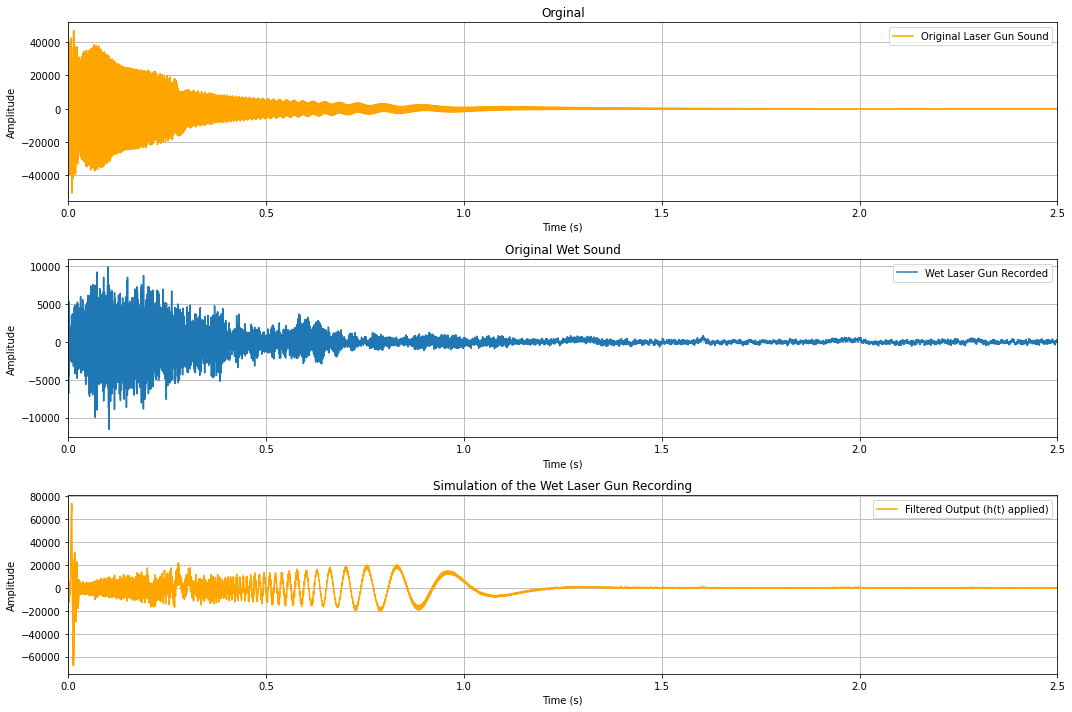

Original Laser Gun Sound


Original Wet Laser Gun Recorded


Simulation of the Wet Laser Gun Recording


In [551]:
# Apply the computed impulse response as a filter to the dry sound x(t) using convolution
filtered_output_full = np.convolve(x, h_t_real, mode='full')  # Use 'full' to capture the entire response

# Print the lengths to verify
print(f"Length of dry signal (x): {len(x)}")
print(f"Length of impulse response (h): {len(h_t_real)}")
print(f"Length of filtered output (full convolution): {len(filtered_output_full)}")

# Use only the first len(x) samples if necessary
filtered_output_full = filtered_output_full[:len(x)]  # Keep the same length as the original signal

# Visualize the filtered output and the wet sound for comparison
plt.figure(figsize=(15, 10))

# Plot  wet sound

# Plot filtered output
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(x)) / fs, x, label='Original Laser Gun Sound', color='orange')
plt.title('Orginal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 2.5)  # Limit x-axis for better visibility
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(len(y)) / fs, y, label='Wet Laser Gun Recorded')
plt.title('Original Wet Sound')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 2.5)  # Limit x-axis for better visibility
plt.legend()

# Plot filtered output
plt.subplot(3, 1, 3)
plt.plot(np.arange(len(filtered_output_full)) / fs, filtered_output_full, label='Filtered Output (h(t) applied)', color='orange')
plt.title('Simulation of the Wet Laser Gun Recording')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0, 2.5)  # Limit x-axis for better visibility
plt.legend()

plt.tight_layout()
plt.show()

# Save the filtered output to a WAV file if needed
print("Original Laser Gun Sound")
ipd.display(ipd.Audio(data=np.int16(x / np.max(np.abs(x)) * 32767), rate=fs))
print("Original Wet Laser Gun Recorded")
ipd.display(ipd.Audio(data=np.int16(y / np.max(np.abs(y)) * 32767), rate=fs))
print("Simulation of the Wet Laser Gun Recording")
ipd.display(ipd.Audio(data=np.int16(filtered_output_full / np.max(np.abs(filtered_output_full)) * 32767), rate=fs))

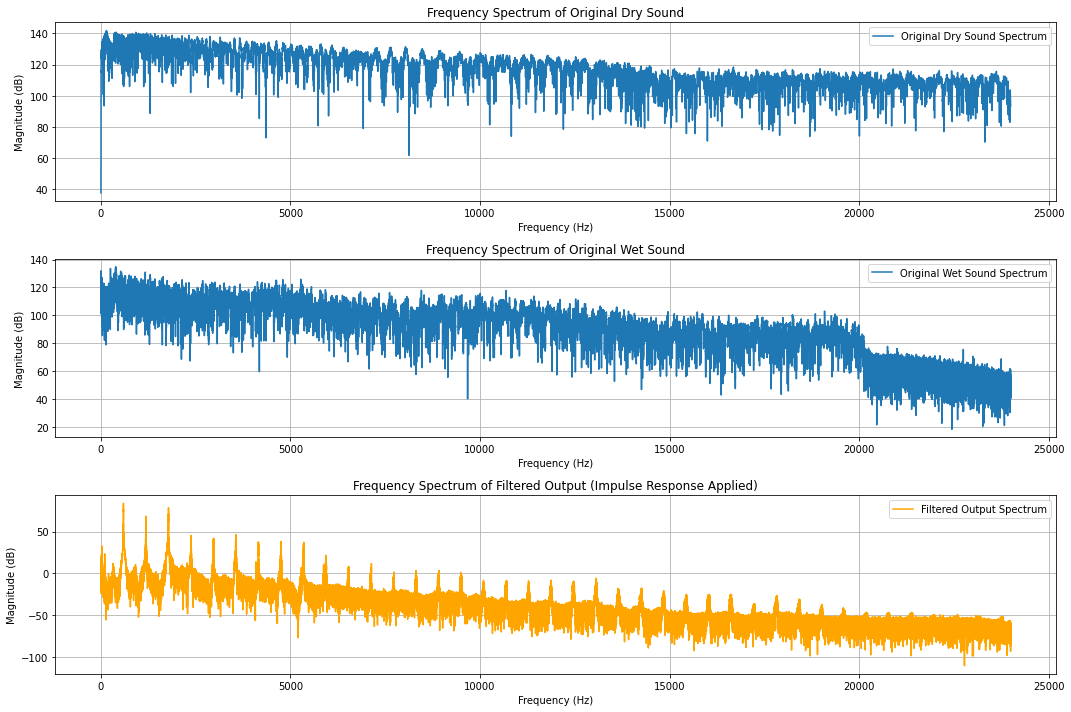

In [552]:
# Compute and visualize the frequency spectra of the dry wet and filtered sounds

# Perform Fourier Transform on dry sound

X = np.fft.fft(x)
freq_X = np.fft.fftfreq(len(x), 1 / fs)

# Perform Fourier Transform on wet sound
Y_wet = np.fft.fft(y)
freq_wet = np.fft.fftfreq(len(y), 1 / fs)

# Perform Fourier Transform on filtered output
Y_filtered = np.fft.fft(filtered_output)
freq_filtered = np.fft.fftfreq(len(filtered_output), 1 / fs)

# Plot the magnitude spectrum for both signals
plt.figure(figsize=(15, 10))

# Plot spectrum of the wet sound
plt.subplot(3, 1, 1)
plt.plot(freq_X[:len(freq_X)//2], 20 * np.log10(np.abs(X[:len(X)//2])), label='Original Dry Sound Spectrum')
plt.title('Frequency Spectrum of Original Dry Sound')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(freq_wet[:len(freq_wet)//2], 20 * np.log10(np.abs(Y_wet[:len(Y_wet)//2])), label='Original Wet Sound Spectrum')
plt.title('Frequency Spectrum of Original Wet Sound')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()

# Plot spectrum of the filtered output
plt.subplot(3, 1, 3)
plt.plot(freq_filtered[:len(freq_filtered)//2], 20 * np.log10(np.abs(Y_filtered[:len(Y_filtered)//2])), color='orange', label='Filtered Output Spectrum')
plt.title('Frequency Spectrum of Filtered Output (Impulse Response Applied)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">

__c) Compare the wet sound (your recorded output) with the computed sound. Discuss whether the process worked effectively in replicating the acoustic environment. What differences or similarities do you observe? Did the filtering process accurately capture the characteristics of the room?__ 

</div>